#  Koncept drift analýza v metabolomické predikci při chladových stresových podmínkách u rostlin

# Instalace a import knihoven

In [1]:
!pip install scikit-learn
!pip install numpy scipy scikit-learn
!pip install scikit-multiflow

In [29]:
# Zpracování dat
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import deque
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

# Validace, trénování a testování modelu
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

# Modely
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Detekce driftu
from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection import EDDM

# Korekce koncept driftu
from skmultiflow.drift_detection import ADWIN
# Metriky
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Načtení dat

Použité datasety jsou ze studie Weiszmann a spol.

WEISZMANN, Jakob; WALTHER, Dirk; CLAUW, Pieter; BACK, Georg; GUNIS, Joanna; REICHARDT, Ilka; KOEMEDA, Stefanie; JEZ, Jakub; NORDBORG, Magnus; SCHWARZEROVA, Jana; PIERIDES, Iro; NÄGELE, Thomas; WECKWERTH, Wolfram. Metabolome plasticity in 241 Arabidopsis thaliana accessions reveals evolutionary cold adaptation processes. Plant Physiology.
2023, roč. 193, č. 2, s. 980–1000. Dostupné z doi: 10.1093/plphys/kiad298

In [30]:
#_______________________________________________________________________________
#
# Načtení dat
#_______________________________________________________________________________
#_______________________________________________________________________________
#
# Data koncentrací měřena při 6 °C ze studie Weiszmann et al.
data_6_degree_c = "Metabolites_Ath_6C.xlsx"
# Data koncentrací měřena při 16 °C ze studie Weiszmann et al.
data_16_degree_c = "Metabolites_Ath_16C.xlsx"
# Data relativní růstové rychlosti (relative growth rate - rgr) měřena při 6 °C ze studie Weiszmann et al.
data_6_degree_rgr = "Phenotype_Ath_RGR_6.xlsx"
# Data relativní růstové rychlosti (relative growth rate - rgr) měřena při 16 °C ze studie Weiszmann et al.
data_16_degree_rgr = "Phenotype_Ath_RGR_16.xlsx"


In [31]:
data_6_degree_c = pd.read_excel(data_6_degree_c, header=None)
data_16_degree_c = pd.read_excel(data_16_degree_c, header=None)

output_data_6_degree_rgr = pd.read_excel(data_6_degree_rgr, header=None)
output_data_16_degree_rgr = pd.read_excel(data_16_degree_rgr, header=None)

# Rozdělení dat

In [32]:
original_data_6_degree_c = data_6_degree_c.copy()
original_data_16_degree_c = data_16_degree_c.copy()

# Názvy metabolitu a ekotypů
names_of_ecotypes = original_data_6_degree_c.iloc[1:, 0].astype(str).apply(lambda x: x.split(',')[0]).tolist()
names_of_metabolites = original_data_6_degree_c.iloc[0, 0].split(',')[1:]
sugars = {'Maltose', 'Fructose', 'Galactose', 'Glucose'}


# Funkce pro extrakci a převod dat
def extract_data(df, col=0):
    column_data = df.iloc[1:, col]
    
    split_rows = column_data.str.split(',')
    values = []
    
    for row in split_rows:
        for val in row[1:]:
            number = float(val.strip())
            values.append(number)
    return np.array(values).reshape(-1,len(row)-1)

# Extrakce dat pro 6°C a 16°C
extract_6_degree_c = extract_data(original_data_6_degree_c)
extract_output_6_degree_rgr = extract_data(output_data_6_degree_rgr)
extract_16_degree_c = extract_data(data_16_degree_c)
extract_output_16_degree_rgr = extract_data(output_data_16_degree_rgr)

# Výběr indexů pro cukry a filtrování metabolitů
sugar_indices = []
metabolites_33 = []
non_sugar_indices = []
metabolites_sugar = []

for index, metabolite in enumerate(names_of_metabolites):
    if metabolite in sugars:
        sugar_indices.append(index)
        metabolites_sugar.append(metabolite)
    else:
        non_sugar_indices.append(index)
        metabolites_33.append(metabolite)

# Výběr dat 33 metabolitů bez 4 cukrů
data_33_6 = np.delete(extract_6_degree_c.copy(), sugar_indices, axis=1)
data_33_16 = np.delete(extract_16_degree_c.copy(), sugar_indices, axis=1)


# Výběr dat pro 4 cukry
data_sugar_6 = extract_6_degree_c.copy()[:, sugar_indices]
data_sugar_16 = extract_16_degree_c.copy()[:, sugar_indices]


# Vykreslení boxplotů

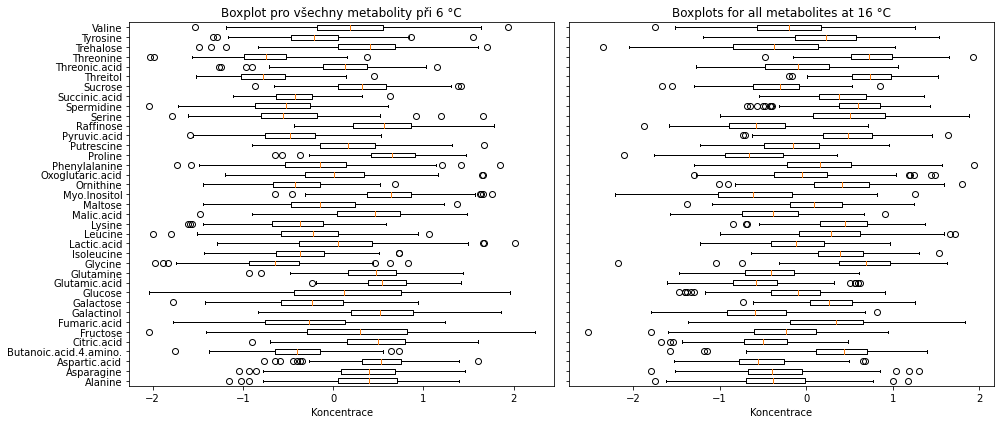

In [33]:
# Vytvoření dvou podgrafů vedle sebe
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  

# Boxplot pro 6 °C
axes[0].boxplot(extract_6_degree_c, vert=False)
axes[0].set_title('Boxplot pro všechny metabolity při 6 °C')
axes[0].set_yticks(range(1, len(names_of_metabolites) + 1))
axes[0].set_yticklabels(names_of_metabolites)
axes[0].set_xlabel('Koncentrace')

# Boxplot pro 16 °C
axes[1].boxplot(extract_16_degree_c, vert=False)
axes[1].set_title('Boxplots for all metabolites at 16 °C')
axes[1].set_yticks(range(1, len(names_of_metabolites) + 1))
axes[1].set_yticklabels(names_of_metabolites)
axes[1].set_xlabel('Koncentrace')

plt.tight_layout()
plt.show()


# Předzpracování dat

In [34]:
# Příprava dat
# Vstupní a výstupní data pro 6 °C pouze pro 33 metabolitů (bez 4 sacharidů)
prepare_6_degree = data_33_6.copy()
rgr_6_degree = extract_output_6_degree_rgr.ravel()

# Vstupní a výstupní data pro 16°C pouze pro 33 metabolitů (bez 4 sacharidů)
prepare_16_degree = data_33_16.copy()
rgr_16_degree = extract_output_16_degree_rgr.ravel()

# Konvertování dat do DataFrame pro lepší práci s daty
data_33_6_df = pd.DataFrame(prepare_6_degree)
data_33_16_df = pd.DataFrame(prepare_16_degree)

# Získání společných sloupců mezi dvěma datovými rámci a vytvoření verze se stejnou strukturou
common_columns = data_33_6_df.columns.intersection(data_33_16_df.columns)
X_6_degree_common = data_33_6_df[common_columns]
X_16_degree_common = data_33_16_df[common_columns]

# Konvertování zpět z DataFrame do numpy arrays pro tréninkový model
c_6_degree = X_6_degree_common.to_numpy()
c_16_degree = X_16_degree_common.to_numpy()

# spojení dat 6 °C a 16 °C
c_combined = np.vstack((c_6_degree, c_16_degree))
rgr_combined = np.concatenate((rgr_6_degree, rgr_16_degree))

# Rozdělení na trénovací a testovací sadu
X_train_6, X_test_6, Y_train_6, Y_test_6 = train_test_split(c_6_degree, rgr_6_degree, test_size = 0.2)
X_train_16, X_test_16, Y_train_16, Y_test_16 = train_test_split(c_16_degree, rgr_16_degree, test_size = 0.2)
X_train_combined, X_test_combined, Y_train_combined, Y_test_combined = train_test_split(c_combined, rgr_combined, test_size = 0.2)

# inicializace modelů
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_lr = LinearRegression()
model_svr = SVR(kernel='rbf')

# Ukládání modelů do slovníku pro snadné vyhledávání
models = {
    "Random Forest Regressor": model_rf,
    "Linear Regression": model_lr,
    "Support Vector Regression": model_svr,
}


# Hodnocení modelu s křížovou validací

In [35]:

def evaluate_model(model, prediction, y):
    """
    Vyhodnotí výkon modelu pomocí různých metrik.

    Parametry:
        model: Model kompatibilní se scikit-learn pro predikci.
        prediction: Predikované hodnoty z modelu.
        y: Skutečné cílové hodnoty.

    Návratová hodnota:
        list: [accuracy, r2, mae, mse, rmse, smape]
            - accuracy (float): Pearsonův korelační koeficient.
            - r2 (float): Koeficient determinace.
            - mae (float): Průměrná absolutní chyba.
            - mse (float): Střední kvadratická chyba.
            - rmse (float): Odmocnina střední kvadratické chyby.
            - smape (float): Symetrická průměrná procentuální chyba.
    """
    # Výpočet metrik
    
    pearson_corr, _ = pearsonr(y, prediction)
    accuracy = pearson_corr
    r2 = r2_score(y, prediction)
    mae = mean_absolute_error(y, prediction)
    mse = mean_squared_error(y, prediction)
    rmse = np.sqrt(mse)
    smape = np.mean(200 * np.abs(prediction - y) / (np.abs(prediction) + np.abs(y)))

    return [accuracy, r2, mae, mse, rmse, smape]

# Koncept drift detekce 


Vyhodnocení kombinací teplot/y Kombinace (6°C + 16°C)

Vyhodnocení modelu: Random Forest Regressor


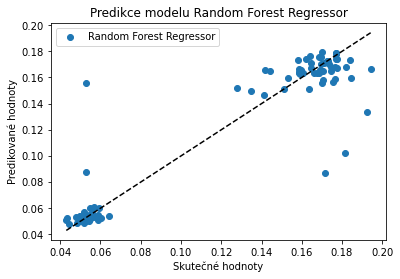

Průměrná přesnost modelu je: -2.1437

Vyhodnocení modelu: Linear Regression


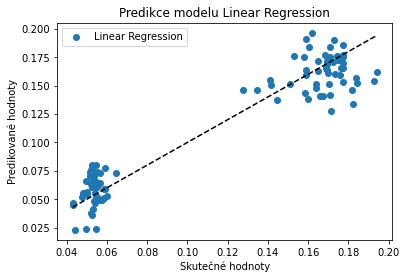

Průměrná přesnost modelu je: -5.0625

Vyhodnocení modelu: Support Vector Regression


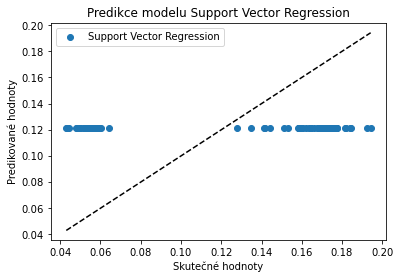

Průměrná přesnost modelu je: -126.7697

Výsledky pro teplotu/teploty Kombinace (6°C + 16°C):
                       Model  Accuracy        R²       MAE       MSE  \
0    Random Forest Regressor  0.942865  0.888273  0.009544  0.000371   
1          Linear Regression  0.953774  0.909025  0.013641  0.000302   
2  Support Vector Regression       NaN -0.006968  0.055942  0.003345   

       RMSE      SMAPE  
0  0.019266   8.433112  
1  0.017385  15.032997  
2  0.057839  52.381230  

Vyhodnocení kombinací teplot/y 6°C

Vyhodnocení modelu: Random Forest Regressor


C:\Users\Terezka\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


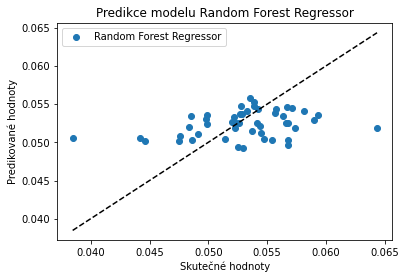

Průměrná přesnost modelu je: 0.1209

Vyhodnocení modelu: Linear Regression


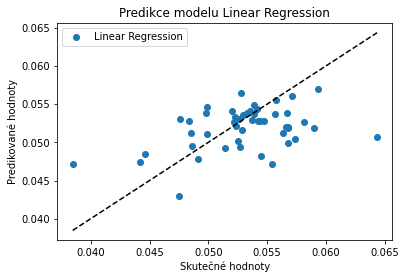

Průměrná přesnost modelu je: 0.1114

Vyhodnocení modelu: Support Vector Regression


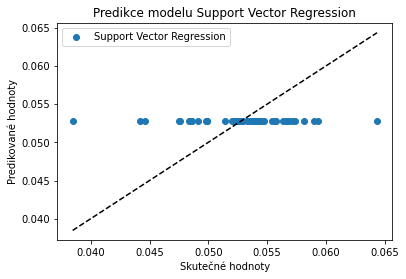

Průměrná přesnost modelu je: -0.1634

Výsledky pro teplotu/teploty 6°C:
                       Model  Accuracy        R²       MAE       MSE  \
0    Random Forest Regressor  0.321354  0.076589  0.003258  0.000018   
1          Linear Regression  0.412521  0.056755  0.003200  0.000018   
2  Support Vector Regression       NaN -0.004245  0.003218  0.000019   

       RMSE     SMAPE  
0  0.004187  6.239914  
1  0.004232  6.152465  
2  0.004367  6.155403  

Vyhodnocení kombinací teplot/y 16°C

Vyhodnocení modelu: Random Forest Regressor


C:\Users\Terezka\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


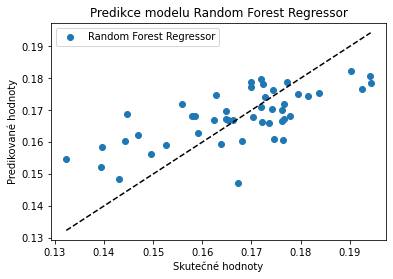

Průměrná přesnost modelu je: 0.2770

Vyhodnocení modelu: Linear Regression


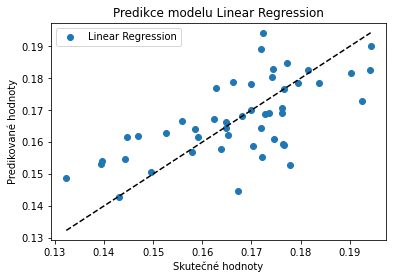

Průměrná přesnost modelu je: 0.2385

Vyhodnocení modelu: Support Vector Regression


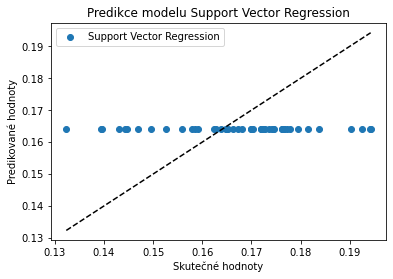

Průměrná přesnost modelu je: -0.2974

Výsledky pro teplotu/teploty 16°C:
                       Model  Accuracy        R²       MAE       MSE  \
0    Random Forest Regressor  0.691478  0.463840  0.008803  0.000111   
1          Linear Regression  0.649990  0.385666  0.009067  0.000128   
2  Support Vector Regression       NaN -0.052245  0.012093  0.000219   

       RMSE     SMAPE  
0  0.010557  5.349865  
1  0.011301  5.473871  
2  0.014790  7.319186  

Vyhodnocení kombinací teplot/y 6°C → 16°C

Vyhodnocení modelu: Random Forest Regressor


C:\Users\Terezka\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


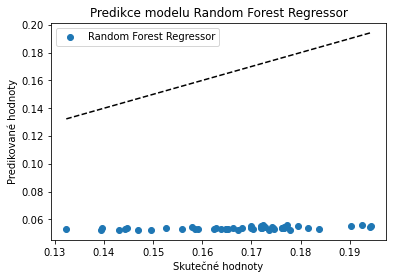

Průměrná přesnost modelu je: 0.2770

Vyhodnocení modelu: Linear Regression


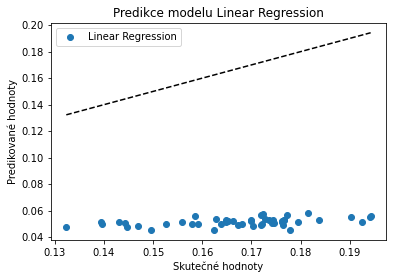

Průměrná přesnost modelu je: 0.2385

Vyhodnocení modelu: Support Vector Regression


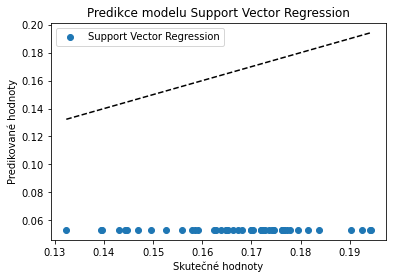

Průměrná přesnost modelu je: -0.2974

Výsledky pro teplotu/teploty 6°C → 16°C:
                       Model  Accuracy         R²       MAE       MSE  \
0    Random Forest Regressor  0.572252 -61.847741  0.113457  0.013065   
1          Linear Regression  0.466859 -64.282700  0.115735  0.013571   
2  Support Vector Regression       NaN -63.118053  0.114548  0.013329   

       RMSE       SMAPE  
0  0.114302  102.218300  
1  0.116496  105.479450  
2  0.115452  103.680528  

Vyhodnocení kombinací teplot/y 16°C → 6°C

Vyhodnocení modelu: Random Forest Regressor


C:\Users\Terezka\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


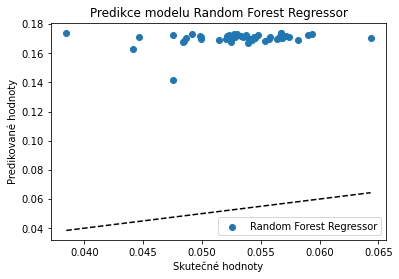

Průměrná přesnost modelu je: 0.1209

Vyhodnocení modelu: Linear Regression


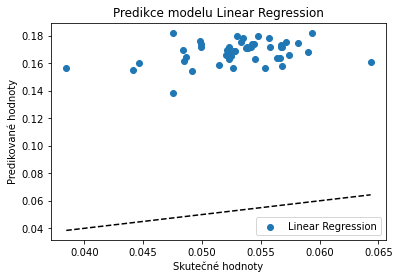

Průměrná přesnost modelu je: 0.1114

Vyhodnocení modelu: Support Vector Regression


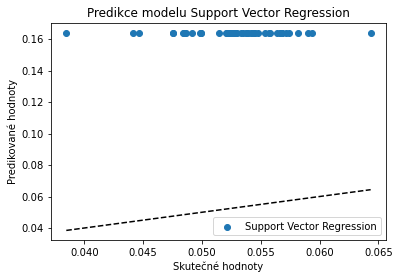

Průměrná přesnost modelu je: -0.1634

Výsledky pro teplotu/teploty 16°C → 6°C:
                       Model  Accuracy          R²       MAE       MSE  \
0    Random Forest Regressor  0.239977 -724.002101  0.117190  0.013765   
1          Linear Regression  0.331371 -698.831196  0.114978  0.013287   
2  Support Vector Regression       NaN -648.591320  0.110968  0.012333   

       RMSE       SMAPE  
0  0.117323  105.072479  
1  0.115268  104.059336  
2  0.111054  102.378808  


C:\Users\Terezka\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [54]:
def detect_drift_ddm(predictions, classifier_name):
    """
    Detekce driftu pomocí metody DDM (Drift Detection Method).

    Parametry:
        predictions (array-like): Predikované hodnoty.
        classifier_name (str): Název modelu.

    Návratová hodnota:
        list: Indexy, na kterých byl detekován drift.
    """
    drift_indices = []
    ddm = DDM()

    for index, predict in enumerate(predictions):
        ddm.add_element(predict)
        if ddm.detected_warning_zone():
            print(f"DDM použitý na modelu {classifier_name}:")
            print(f"Varovná zóna detekována na indexu: {index}")
        if ddm.detected_change():
            print(f"DDM použitý na modelu {classifier_name}:")
            print(f"Detekován koncept drift na indexu: {index}")
            drift_indices.append(index)

    return drift_indices


def detect_drift_eddm(predictions, classifier_name):
    """
    Detekce driftu pomocí metody EDDM (Early Drift Detection Method).

    Parametry:
        predictions (array-like): Predikované hodnoty.
        classifier_name (str): Název modelu.

    Návratová hodnota:
        list: Indexy, na kterých byl detekován drift.
    """
    drift_indices = []
    eddm = EDDM()

    for index, predict in enumerate(predictions):
        eddm.add_element(predict)
        if eddm.detected_warning_zone():
            print(f"EDDM použitý na modelu {classifier_name}:")
            print(f"Varovná zóna detekována na indexu: {index}")
        if eddm.detected_change():
            print(f"EDDM použitý na modelu {classifier_name}:")
            print(f"Detekován koncept drift na indexu: {index}")
            drift_indices.append(index)

    return drift_indices


def evaluate_models_on_dataset(models, x_train, y_train, x_test, y_test, x_original,
                              y_original, dataset_name, cv=7):
    """
    Vyhodnocení více modelů na konkrétním datasetu včetně detekce driftu.

    Parametry:
        models (dict): Slovník modelů ve formátu {název: model}.
        x_train (array-like): Trénovací vstupní data.
        y_train (array-like): Trénovací cílové hodnoty.
        x_test (array-like): Testovací vstupní data.
        y_test (array-like): Testovací cílové hodnoty.
        x_original (array-like): Původní vstupní data pro křížovou validaci.
        y_original (array-like): Původní cílové hodnoty pro křížovou validaci.
        dataset_name (str): Název datasetu pro výpisy.
        cv (int): Počet foldů pro křížovou validaci (výchozí: 7).

    Návratová hodnota:
        tuple: (DataFrame výsledků, seznam driftů DDM, seznam driftů EDDM)
    """
    results = []
    detected_drift_ddm = []
    detected_drift_eddm = []

    print(f"\nVyhodnocení kombinací teplot/y {dataset_name}")

    for name, model in models.items():
        print(f"\nVyhodnocení modelu: {name}")
        # Trénování modelu na trénovacích datech
        model.fit(x_train, y_train)
        # Predikce na testovacích datech
        test_predictions = model.predict(x_test)

        plt.scatter(y_test, test_predictions, label=name)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
        plt.xlabel('Skutečné hodnoty')
        plt.ylabel('Predikované hodnoty')
        plt.title(f'Predikce modelu {name}')
        plt.legend()
        plt.show()

        # Vyhodnocení modelu na testovacích datech a pomocí křížové validace
        score = cross_val_score(model, x_original, y_original, cv=cv)
        print(f"Průměrná přesnost modelu je: {score.mean():.4f}")

        metrics = evaluate_model(model, test_predictions, y_test)
        results.append([name] + metrics)

        # Detekce driftu na testovacích predikcích
        drift_ddm_indices = detect_drift_ddm(test_predictions, name)
        drift_eddm_indices = detect_drift_eddm(test_predictions, name)

        detected_drift_ddm.append(drift_ddm_indices)
        detected_drift_eddm.append(drift_eddm_indices)

    df_results = pd.DataFrame(
        results,
        columns=["Model", "Accuracy", "R²", "MAE", "MSE", "RMSE", "SMAPE"]
    )

    print(f"\nVýsledky pro teplotu/teploty {dataset_name}:")
    print(df_results)

    return df_results, detected_drift_ddm, detected_drift_eddm


# Volání funkcí
_, detected_drift_ddm_combined, detected_drift_eddm_combined = evaluate_models_on_dataset(
    models,
    X_train_combined,
    Y_train_combined,
    X_test_combined,
    Y_test_combined,
    c_combined,
    rgr_combined,
    "Kombinace (6°C + 16°C)"
)

_, detected_drift_ddm_6, detected_drift_eddm_6 = evaluate_models_on_dataset(
    models,
    X_train_6,
    Y_train_6,
    X_test_6,
    Y_test_6,
    prepare_6_degree,
    rgr_6_degree,
    "6°C"
)

_, detected_drift_ddm_16, detected_drift_eddm_16 = evaluate_models_on_dataset(
    models,
    X_train_16,
    Y_train_16,
    X_test_16,
    Y_test_16,
    prepare_16_degree,
    rgr_16_degree,
    "16°C"
)

_, detected_drift_ddm_6_to_16, detected_drift_eddm_6_to_16 = evaluate_models_on_dataset(
    models,
    X_train_6,
    Y_train_6,
    X_test_16,
    Y_test_16,
    prepare_16_degree,
    rgr_16_degree,
    "6°C → 16°C"
)

_, detected_drift_ddm_16_to_6, detected_drift_eddm_16_to_6 = evaluate_models_on_dataset(
    models,
    X_train_16,
    Y_train_16,
    X_test_6,
    Y_test_6,
    prepare_6_degree,
    rgr_6_degree,
    "16°C → 6°C"
)

# Výsledky analýzy koncentrace metabolitů po detekci driftu konceptu

In [52]:
combine_data_sugar = np.concatenate((data_sugar_6, data_sugar_16))
ecotype = np.concatenate((names_of_ecotypes, names_of_ecotypes))
n_rows = len(data_sugar_6)

# ----------------------------------------------------------------------
# Finalní koncentrace cukrů s detekovaným koncept driftem za použití DDM
#-----------------------------------------------------------------------
def process_sugar_concentration_ddm(sugar, indices, data, ecotyp):
    """
    Zpraovoní koncentrací cukrů při 6 °C a 16 °C na základě detekovaných 
    indexů koncept driftu (DDM).

    Args:
        sugars (list): Seznam názvů metabolitů.
        indices (list of list of int): Indexy detekovaného driftu.
        data (ndarray): Kombinované vstupní hodnoty koncentrací.
        ecotyp (ndarray): Seznam názvů ekotypů odpovídajících řádkům dat.

    Returns:
        tuple: Dvě pole koncentrací pro 6 °C a 16 °C.
    """
    concentrations_6 = []
    concentrations_16 = []

    for idx, name in enumerate(sugars):
        metabolite_concentrations_6 = []
        metabolite_concentrations_16 = []

        for index_list in indices:
            for index in index_list:
                if 0 <= index < len(data):
                
                    print(
                        f" Koncentrace metabolitu {name} na indexu {index}, "
                        f"hodnota: {data[index][idx]}, ekotyp: {ecotyp[index]}"
                    )
                    metabolite_concentrations_16.append(data[index][idx])

                    # Check and print concentration for 6°C
                    if index - n_rows >= 0:
                        print(
                            f" Koncentrace metabolit při 6°C {name}"
                            f" na indexu {index - n_rows}, "
                            f" hodnota: {data[index - n_rows][idx]}, "
                            f"ekotyp: {ecotyp[index - n_rows]}"
                        )
                        metabolite_concentrations_6.append(data[index - n_rows][idx])

        concentrations_6.append(metabolite_concentrations_6)
        concentrations_16.append(metabolite_concentrations_16)

    return concentrations_6, concentrations_16


# ------------------------------------------------------------------------
# Finalní koncentrace cukrů s detekovaným koncept driftem za použití EDDM
#-------------------------------------------------------------------------

def process_sugar_concentration_eddm(sugar, indices, data, ecotyp):
    """
    Zpracuje koncentrace cukrů při 6 °C a 16 °C na základě detekovaných 
    indexů koncept driftu (EDDM).

    Args:
        sugars (list): Seznam názvů metabolitů.
        indices (list of list of int): Indexy detekovaného driftu.
        data (ndarray): Kombinované vstupní hodnoty koncentrací.
        ecotyp (ndarray): Seznam názvů ekotypů odpovídajících řádkům dat.

    Returns:
        tuple: Dvě pole koncentrací pro 6 °C a 16 °C.
    """
    concentrations_6 = []
    concentrations_16 = []

    for idx, name in enumerate(sugar):
        metabolite_concentrations_6 = []
        metabolite_concentrations_16 = []

        for index_list in indices:
            for index in index_list:
                if 0 <= index < len(data):
                
                    print(
                        f" Koncentrace metabolitu {name} na indexu {index}, "
                        f"hodnota: {data[index][idx]}, ekotyp: {ecotyp[index]}"
                    )
                    metabolite_concentrations_16.append(data[index][idx])

                    if index - n_rows >= 0:
                        print(
                            f" Koncentrace metabolit při 6°C {name}"
                            f" na indexu {index - n_rows}, "
                            f" hodnota: {data[index - n_rows][idx]}, "
                            f"ekotyp: {ecotyp[index - n_rows]}"
                        )
                        metabolite_concentrations_6.append(data[index - n_rows][idx])

        concentrations_6.append(metabolite_concentrations_6)
        concentrations_16.append(metabolite_concentrations_16)

    return concentrations_6, concentrations_16


# Zobrazení výsledků
concentrations_6, concentrations_16 = process_sugar_concentration_ddm(
    metabolites_sugar, detected_drift_ddm_combined, combine_data_sugar, ecotype
)

print("\n Výsledky pro kombinovaný dataset (6°C + 16°C):")
print("\n Indexy detekovaného driftu (DDM):")
process_sugar_concentration_ddm(
    metabolites_sugar, detected_drift_ddm_combined, combine_data_sugar, ecotype
)
print("\n Indexy detekovaného driftu (EDDM):")
process_sugar_concentration_eddm(
    metabolites_sugar, detected_drift_eddm_combined, combine_data_sugar, ecotype
)

print("\nResults for 6°C Prediction:")
print("\n Indexy detekovaného driftu (DDM):")
process_sugar_concentration_ddm(
    metabolites_sugar, detected_drift_ddm_6, combine_data_sugar, ecotype
)
print("\n Indexy detekovaného driftu (EDDM):")
process_sugar_concentration_eddm(
    metabolites_sugar, detected_drift_eddm_6, combine_data_sugar, ecotype
)

print("\nResults for 16°C Prediction:")
print("\n Indexy detekovaného driftu (DDM):")
process_sugar_concentration_ddm(
    metabolites_sugar, detected_drift_ddm_16, combine_data_sugar, ecotype
)
print("\n Indexy detekovaného driftu(EDDM):")
process_sugar_concentration_eddm(
    metabolites_sugar, detected_drift_eddm_16, combine_data_sugar, ecotype
)

print("\nPrediction from 6°C to 16°C")
print("\n Indexy detekovaného driftu(DDM):")
process_sugar_concentration_ddm(
    metabolites_sugar, detected_drift_ddm_6_to_16, combine_data_sugar, ecotype
)
print("\n Indexy detekovaného driftu (EDDM):")
process_sugar_concentration_eddm(
    metabolites_sugar, detected_drift_eddm_6_to_16, combine_data_sugar, ecotype
)

print("\nPrediction from 16°C to 6°C")
print("\n Indexy detekovaného driftu (DDM):")
process_sugar_concentration_ddm(
    metabolites_sugar, detected_drift_ddm_16_to_6, combine_data_sugar, ecotype
)
print("\n Indexy detekovaného driftu (EDDM):")
process_sugar_concentration_eddm(
    metabolites_sugar, detected_drift_eddm_16_to_6, combine_data_sugar, ecotype
)


 Výsledky pro kombinovaný dataset (6°C + 16°C):

 Indexy detekovaného driftu (DDM):

 Indexy detekovaného driftu (EDDM):

Results for 6°C Prediction:

 Indexy detekovaného driftu (DDM):

 Indexy detekovaného driftu (EDDM):

Results for 16°C Prediction:

 Indexy detekovaného driftu (DDM):

 Indexy detekovaného driftu(EDDM):

Prediction from 6°C to 16°C

 Indexy detekovaného driftu(DDM):

 Indexy detekovaného driftu (EDDM):

Prediction from 16°C to 6°C

 Indexy detekovaného driftu (DDM):

 Indexy detekovaného driftu (EDDM):


([[], [], [], []], [[], [], [], []])

# Vizualizace koncentrací metabolitů pro 6 °C a 16 °C s detekcí koncept driftu

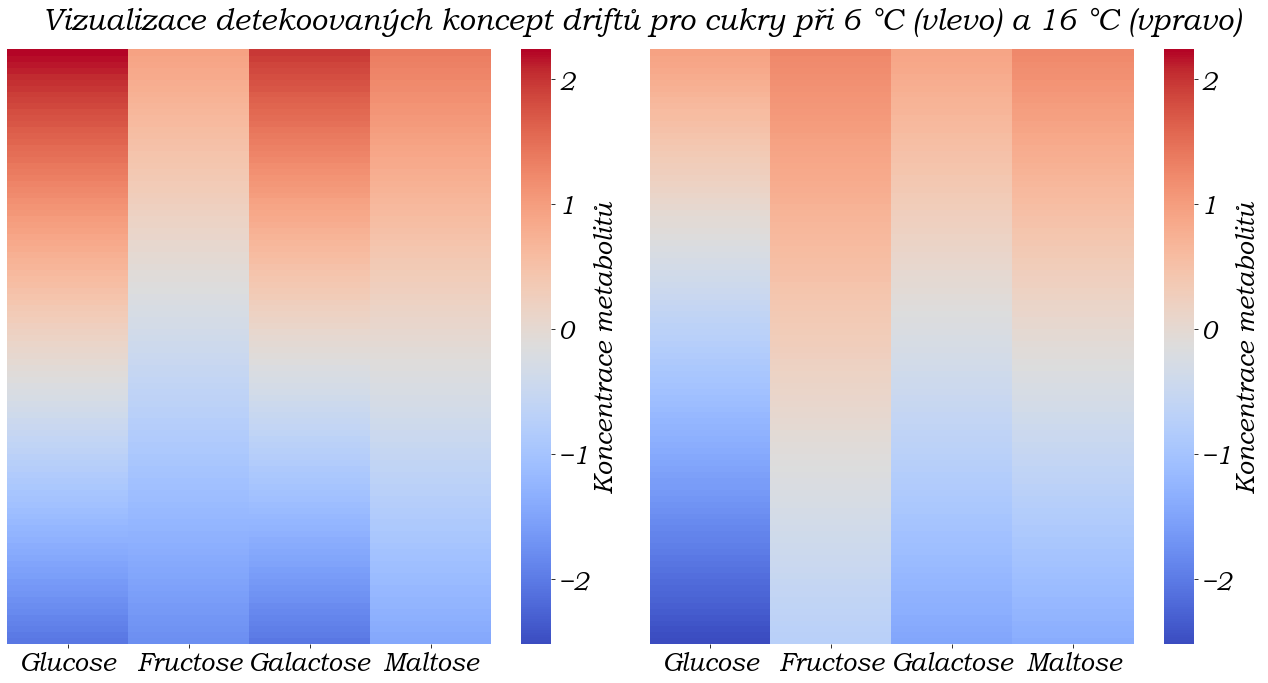

In [53]:
# ----------------------------------------------
# Heatmapa pro 6°C
# ----------------------------------------------

# Minimum a maximum
min_values_6 = np.min(data_sugar_6, axis=0)
max_values_6 = np.max(data_sugar_6, axis=0)

# Vytvoření matice hodnot mezi minimem a maximem pro každý metabolit
matrix_for_6 = []
for min_val, max_val in zip(min_values_6, max_values_6):
    matrix_for_6.append(np.linspace(min_val, max_val, 100))

matrix_for_6 = np.array(matrix_for_6)

# ----------------------------------------------
# Heatmap pro 16°C
# ----------------------------------------------

# Minimum a maximum
min_values_16 = np.min(data_sugar_16, axis=0)
max_values_16 = np.max(data_sugar_16, axis=0)

# Vytvoření matice hodnot mezi minimem a maximem pro každý metabolit
matrix_for_16 = []
for min_val, max_val in zip(min_values_16, max_values_16):
    matrix_for_16.append(np.linspace(min_val, max_val, 100))

matrix_for_16 = np.array(matrix_for_16)

# ----------------------------------------------
# Propojení do jedné heatmapy
# ----------------------------------------------

# Globální minimum a maximum
global_min = min(np.min(matrix_for_6), np.min(matrix_for_16))
global_max = max(np.max(matrix_for_6), np.max(matrix_for_16))

# Vykreslení heatmaps
plt.figure(figsize=(18, 9))

# První Heatmapa (6°C)
plt.subplot(1, 2, 1)
sns.heatmap(
    matrix_for_6.T,
    cmap='coolwarm',
    xticklabels=sugars,
    yticklabels=False,
    cbar_kws={'label': 'Koncentrace metabolitů'},
    vmin=global_min, vmax=global_max)

cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=26)

for label in cbar.ax.get_yticklabels():
    label.set_fontstyle('italic')
    label.set_fontname('Bookman Old Style')

plt.xticks(fontsize=26, fontstyle='italic', family='Bookman Old Style') 

#plt.title("Visualization of drift detection concepts as a function of individual metabolite concentration for 6°C")

cbar.set_label('Koncentrace metabolitů', fontsize=26, fontstyle='italic', family='Bookman Old Style')

plt.gca().invert_yaxis()

# Vykreslení detekovaných koncept driftů
for idx, metabolite in enumerate(sugars):
    concs = concentrations_6[idx]  
    for conc in concs:
        y_position = np.abs(np.linspace(min_values_6[idx], max_values_6[idx], 100) - conc).argmin()
        plt.scatter(idx, y_position, color='black', s=1, zorder=1)

# Druhá Heatmapa (16°C)
plt.subplot(1, 2, 2)
sns.heatmap(
    matrix_for_16.T,
    cmap='coolwarm',
    xticklabels=sugars,
    yticklabels=False,
    cbar_kws={'label': 'Koncentrace metabolitů'},
    vmin=global_min, vmax=global_max
)
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=26) 

for label in cbar.ax.get_yticklabels():
    label.set_fontstyle('italic')
    label.set_fontname('Bookman Old Style')

plt.xticks(fontsize=26, fontstyle='italic', family='Bookman Old Style')
#plt.title("Visualization of drift detection concepts as a function of individual metabolite concentration for 16°C")

cbar.set_label('Koncentrace metabolitů', fontsize=26, fontstyle='italic', family='Bookman Old Style')

plt.gca().invert_yaxis()

# Vykreslení detekovaných koncept driftů
for idx, metabolite in enumerate(sugars):
    concs = concentrations_16[idx]
    for conc in concs:
        y_position = np.abs(np.linspace(min_values_16[idx], max_values_16[idx], 100) - conc).argmin()
        plt.scatter(idx, y_position, color='black', s=1, zorder=1)
        
plt.suptitle(f"Vizualizace detekoovaných koncept driftů pro cukry při 6 °C (vlevo) a 16 °C (vpravo)", fontsize=30, fontstyle='italic', family='Bookman Old Style', y = 1.05)
plt.tight_layout()
plt.show()


# Korekce koncept driftu

In [ ]:
# Drift indexy
rf_drift_indices = detected_drift_ddm_combined[0]  
lr_drift_indices = detected_drift_ddm_combined[1] 
svr_drift_indices = detected_drift_ddm_combined[2]

In [31]:
# Varianta 1 - korekce koncept drfitu pomocí resetu
def correct_drift_with_reset(X, y, drift_indices, model_name, model, window_size = 20):
      
    print(f"\nKorekce driftu pro model {model_name} (Varianta 1: Reset modelu)")
    
    current_model = model.__class__(**model.get_params())  
    y_pred = np.zeros_like(y)
    data_window = deque(maxlen=window_size)  
    is_model_fitted = False
    
    for i, (x_i, y_i) in enumerate(zip(X, y)):
        data_window.append((x_i, y_i)) 
        
        # Reset modelu při detekci driftu
        if i in drift_indices:
            print(f"Reset modelu na indexu {i} kvůli detekovanému driftu")
            current_model = model.__class__(**model.get_params())
            is_model_fitted = False
            
        # Trénování modelu, pokud není natrénován   
        if not is_model_fitted: 
            X_window, y_window = zip(*data_window)
            current_model.fit(np.array(X_window), np.array(y_window))
            is_model_fitted = True
        
        # Predikce
        if is_model_fitted:
            y_pred_i = current_model.predict([x_i])[0]
            y_pred[i] = y_pred_i
        else:
            y_pred[i] = 0
        
        # Aktualizace modelu
        try:
            current_model.partial_fit([x_i], [y_i])
        except AttributeError:
            current_model.fit([x_i], [y_i])
            
    return y_pred, current_model

# Aplikace korekce driftu na kombinovaná data
print("\n=== Korekce koncept driftu ===")

# Varianta 1: Reset modelu
rf_pred_reset, rf_model_reset = correct_drift_with_reset(
    c_combined, rgr_combined, rf_drift_indices, "Random Forest", model_rf
)
lr_pred_reset, lr_model_reset = correct_drift_with_reset(
    c_combined, rgr_combined, lr_drift_indices, "Linear Regression", model_lr
)
svr_pred_reset, svr_model_reset = correct_drift_with_reset(
    c_combined, rgr_combined, svr_drift_indices, "Support Vector Regression", model_svr
)




=== Korekce koncept driftu ===

Korekce driftu pro model Random Forest (Varianta 1: Reset modelu)
Reset modelu na indexu 323 kvůli detekovanému driftu

Korekce driftu pro model Linear Regression (Varianta 1: Reset modelu)
Reset modelu na indexu 325 kvůli detekovanému driftu

Korekce driftu pro model Support Vector Regression (Varianta 1: Reset modelu)


In [38]:
# Varianta 2: Ensemble RandomForestRegressor s ADWIN vážením

def correct_drift_with_rf_ensemble(X, y, drift_indices, model_name, n_estimators=10):
    """
    Korekce koncept driftu pomocí ensemble RandomForestRegressor s vážením podle ADWIN.

    Args:
        X (ndarray): Vstupní data.
        y (ndarray): Cílové hodnoty.
        drift_indices (list): Indexy detekovaného driftu.
        model_name (str): Název modelu.

    Returns:
        tuple: Aktualizované predikce a seznam modelů.
    """
    print(f"\nKorekce driftu pro model {model_name} (Varianta 2: RF Ensemble s ADWIN)")
    
    # Inicializace modelů
    models = []
    for i in range(n_estimators):
        model = RandomForestRegressor(n_estimators, random_state=42+i) 
        models.append(model)
        
    # Počáteční váhy
    weights = [1.0 / n_estimators] * n_estimators  
    adwin = ADWIN()  # Detektor driftu pro úpravu vah
    y_pred = np.zeros_like(y)

    # Počáteční trénování modelů
    min_samples = min(1, len(X))  
    if min_samples > 0:
        for model in models:
            model.fit(X[:min_samples], y[:min_samples])

    for i, (x_i, y_i) in enumerate(zip(X, y)):
        # Predikce z ensemble
        predictions = [model.predict([x_i])[0] for model in models]
        y_pred_i = np.average(predictions, weights=weights)
        y_pred[i] = y_pred_i

        # Detekce driftu pro vážení modelů
        error = abs(y_i - y_pred_i)
        adwin.add_element(error)
        if i in drift_indices or adwin.detected_change():
            print(f"Detekovaný drift na indexu {i}, aktualizace vah ensemble")
            
            # Snížení vah špatně fungujících modelů
            for j, pred in enumerate(predictions):
                model_error = abs(y_i - pred)
                # Exponenciální útlum
                weights[j] *= np.exp(-model_error)
            # Normalizace vah   
            weights = [w / sum(weights) for w in weights]  

        # Učení modelů
        for model in models:
            model.fit([x_i], [y_i])
            
    return y_pred, models

# Aplikace korekce driftu na kombinovaná data
print("\n=== Korekce koncept driftu ===")

# Varianta 2: RF Ensemble s ADWIN
rf_pred_ensemble, rf_model_ensemble = correct_drift_with_rf_ensemble(
    c_combined, rgr_combined, rf_drift_indices, "Random Forest"
)

lr_pred_ensemble, lr_model_ensemble = correct_drift_with_rf_ensemble(
    c_combined, rgr_combined, lr_drift_indices, "Linear Regression"
)
svr_pred_ensemble, svr_model_ensemble = correct_drift_with_rf_ensemble(
    c_combined, rgr_combined, svr_drift_indices, "Support Vector Regression"
)


=== Korekce koncept driftu ===

Korekce driftu pro model Random Forest (Varianta 2: RF Ensemble s ADWIN)
Detekovaný drift na indexu 323, aktualizace vah ensemble

Korekce driftu pro model Linear Regression (Varianta 2: RF Ensemble s ADWIN)
Detekovaný drift na indexu 325, aktualizace vah ensemble

Korekce driftu pro model Support Vector Regression (Varianta 2: RF Ensemble s ADWIN)


In [37]:
# 3. Varianta
def correct_drift_autoscaling(X, y, drift_indices, model_name, model, window_size = 10):
    """
    Korekce koncept driftu autoskalováním dat v posuvném okně a přeučením modelu.

    Args:
        X (ndarray): Vstupní data.
        y (ndarray): Cílové hodnoty.
        drift_indices (list): Indexy detekovaného driftu.
        model_name (str): Název modelu.
        model: Instance modelu (RandomForestRegressor, LinearRegression, SVR).
        window_size (int): Velikost posuvného okna.

    Returns:
        tuple: Aktualizované predikce a nový model.
    """
    print(f"\nKorekce driftu pro model {model_name} (Škálování: Autoscaling)")
    
    current_model = model.__class__(**model.get_params())  # Nová instance modelu
    y_pred = np.zeros_like(y)
    data_window = deque(maxlen=window_size)  # Posuvné okno pro data
    scaler = None  # Inicializace scaleru

    # Inicializace modelu trénováním na prvních window_size vzorcích
    initial_size = min(window_size, len(X))
    if initial_size >= 10:  # Minimální počet vzorků pro počáteční trénování
        X_initial = X[:initial_size]
        y_initial = y[:initial_size]
        
        # Počáteční autoskalování
        scaler = StandardScaler()
        X_initial_scaled = scaler.fit_transform(X_initial)
        
        # Počáteční trénování modelu
        current_model.fit(X_initial_scaled, y_initial)
    else:
        # Pokud není dost dat, natrénuj model na všech dostupných datech bez škálování
        current_model.fit(X[:initial_size], y[:initial_size])
        scaler = None

    for i, (x_i, y_i) in enumerate(zip(X, y)):
        data_window.append((x_i, y_i))  # Uložení dat do okna

        # Pokud je detekován drift, aplikuj autoskalování a přeuč model
        if i in drift_indices:
            print(f"Detekovaný drift na indexu {i}, aplikace autoskalování a přeučení modelu")
            if len(data_window) >= 10:  # Minimální počet vzorků pro škálování a přeučení
                X_window, y_window = zip(*data_window)
                X_window = np.array(X_window)
                y_window = np.array(y_window)

                # Aplikace autoskalování
                scaler = StandardScaler()
                X_window_scaled = scaler.fit_transform(X_window)

                # Přeučení modelu na škálovaných datech
                current_model.fit(X_window_scaled, y_window)

                # Škálování aktuálního vzorku pro predikci
                x_i_scaled = scaler.transform([x_i])[0]
            else:
                x_i_scaled = x_i  # Pokud není dost dat, použij neškálovaná data
        else:

            x_i_scaled = scaler.transform([x_i])[0] if scaler else x_i

        # Predikce
        y_pred_i = current_model.predict([x_i_scaled])[0]
        y_pred[i] = y_pred_i

        # Postupné učení modelu
        try:
            current_model.partial_fit([x_i_scaled], [y_i])
            
        except AttributeError:
            current_model.fit([x_i_scaled], [y_i])  
            
    return y_pred, current_model

# Aplikace korekce driftu na kombinovaná data
print("\n=== Korekce koncept driftu ===")

# Korekce driftu s Autoscaling
rf_pred_scaled, rf_model_scaled = correct_drift_autoscaling(
    c_combined, rgr_combined, rf_drift_indices, "Random Forest", model_rf
)
lr_pred_scaled, lr_model_scaled = correct_drift_autoscaling(
    c_combined, rgr_combined, lr_drift_indices, "Linear Regression", model_lr
)
svr_pred_scaled, svr_model_scaled = correct_drift_autoscaling(
    c_combined, rgr_combined, svr_drift_indices, "Support Vector Regression", model_svr
)



=== Korekce koncept driftu ===

Korekce driftu pro model Random Forest (Škálování: Autoscaling)
Detekovaný drift na indexu 323, aplikace autoskalování a přeučení modelu

Korekce driftu pro model Linear Regression (Škálování: Autoscaling)
Detekovaný drift na indexu 325, aplikace autoskalování a přeučení modelu

Korekce driftu pro model Support Vector Regression (Škálování: Autoscaling)


In [40]:
def correct_drift_log_transformation(X, y, drift_indices, model_name, model, window_size=100, tolerance=0.01):
    """
    Korekce koncept driftu logaritmickou transformací dat v posuvném okně a přeučením modelu.

    Args:
        X (ndarray): Vstupní data.
        y (ndarray): Cílové hodnoty.
        drift_indices (list): Indexy detekovaného driftu.
        model_name (str): Název modelu.
        model: Instance modelu (RandomForestRegressor, LinearRegression, SVR).
        window_size (int): Velikost posuvného okna.

    Returns:
        tuple: Aktualizované predikce a nový model.
    """
      
    print(f"\nKorekce driftu pro model {model_name} (Transformace: Log Transformation)")
    current_model = model.__class__(**model.get_params()) 
    y_pred = np.zeros_like(y)
    data_window = deque(maxlen=window_size)  

    # Inicializace modelu trénováním na prvních window_size vzorcích
    initial_size = min(window_size, len(X))
    if initial_size >= 10:  # Minimální počet vzorků pro počáteční trénování
        X_initial = X[:initial_size]
        y_initial = y[:initial_size]
        y_initial_log = np.log1p(y_initial)
        current_model.fit(X_initial, y_initial_log)
        
    else:
        current_model.fit(X[:initial_size], y[:initial_size])

    for i, (x_i, y_i) in enumerate(zip(X, y)):
        data_window.append((x_i, y_i)) 

        # Pokud je detekován drift, aplikuj logaritmickou transformaci a přeuč model
        if i in drift_indices:
            print(f"Detekovaný drift na indexu {i}, aplikace logaritmické transformace a přeučení modelu")
            if len(data_window) >= 10:  # Minimální počet vzorků pro transformaci a přeučení
                X_window, y_window = zip(*data_window)
                X_window = np.array(X_window)
                y_window = np.array(y_window)

                # Logaritmická transformace cílové proměnné
                y_window_log = np.log1p(y_window)

                # Přeučení modelu na transformovaných datech
                current_model.fit(X_window, y_window_log)

                # Predikce s log transformací
                y_pred_log = current_model.predict([x_i])[0]
                y_pred_i = np.expm1(y_pred_log)  # Zpětná transformace
            else:
                y_pred_i = current_model.predict([x_i])[0]  # Bez transformace
        else:
            # Pokud není drift, proveď predikci s aktuálním modelem
            y_pred_log = current_model.predict([x_i])[0]
            y_pred_i = np.expm1(y_pred_log)  # Zpětná transformace

        y_pred[i] = y_pred_i

        # Postupné učení modelu s log transformací
        try:
            current_model.partial_fit([x_i], [np.log1p(y_i)])
        except AttributeError:
            current_model.fit([x_i], [np.log1p(y_i)])  # Fallback na fit

        
        
    return y_pred, current_model

# Aplikace korekce driftu na kombinovaná data
print("\n=== Korekce koncept driftu ===")

# Korekce driftu s Log Transformation
rf_pred_log, rf_model_log = correct_drift_log_transformation(
    c_combined, rgr_combined, rf_drift_indices, "Random Forest", model_rf
)
lr_pred_log, lr_model_log = correct_drift_log_transformation(
    c_combined, rgr_combined, lr_drift_indices, "Linear Regression", model_lr
)
svr_pred_log, svr_model_log = correct_drift_log_transformation(
    c_combined, rgr_combined, svr_drift_indices, "Support Vector Regression", model_svr
)


=== Korekce koncept driftu ===

Korekce driftu pro model Random Forest (Transformace: Log Transformation)
Detekovaný drift na indexu 323, aplikace logaritmické transformace a přeučení modelu

Korekce driftu pro model Linear Regression (Transformace: Log Transformation)
Detekovaný drift na indexu 325, aplikace logaritmické transformace a přeučení modelu

Korekce driftu pro model Support Vector Regression (Transformace: Log Transformation)


In [72]:
def correct_concept_drift_all_out(X, y, drift_indices_list, model, model_name, cv=7):
    """
    Odstranění dat s detekovaným koncept driftem.

    Parameters:
        X (array-like): Vstupní data (features).
        y (array-like): Cílové hodnoty.
        drift_indices_list (list of lists): Seznam seznamů indexů detekovaného driftu pro různé modely.
        model: Model pro přetrénování.
        model_name (str): Název modelu pro výpis.
        cv (int, default=7): Počet foldů pro křížovou validaci.

    Returns:
        tuple: (přetrénovaný model, nová data X, nová data y, predikce, metriky)
    """
    print(f"\nKorekce driftu pro model {model_name} (Metoda: Odstranění dat s driftem s úpravou indexů)")

    # Počet ekotypů
    all_ecotypes = len(names_of_ecotypes)
    
    # Sjednotit všechny indexy driftu a upravit indexy >= all_ecotypes
    unique_drift_indices = set()
    for indices in drift_indices_list:
        for idx in indices:
            unique_drift_indices.add(idx)  # Přidat původní index
            if idx >= all_ecotypes:
                unique_drift_indices.add(idx - all_ecotypes)  # Přidat index po odečtení ekotypů
    
    print(f"Sjednocené indexy driftu po úpravě: {unique_drift_indices}")

    # Odstranění data s detekovaným driftem
    mask = np.ones(len(X), dtype=bool)
    mask[list(unique_drift_indices)] = False
    X_corrected = X[mask]
    y_corrected = y[mask]
    
    # Přetrénování modelu
    current_model = model.__class__(**model.get_params())  # Nová instance modelu
    current_model.fit(X_corrected, y_corrected)
    
    # Vyhodnocení přetrénovaného modelu
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    predictions = cross_val_predict(current_model, X_corrected, y_corrected, cv=kf)
    print(current_model)
    return current_model, X_corrected, y_corrected, predictions

# Aplikace korekce driftu na kombinovaná data
print("\n=== Korekce koncept driftu ===")


# Kombinace všech indexů driftu
all_drift_indices = [rf_drift_indices, lr_drift_indices, svr_drift_indices]


# Korekce driftu pro každý model s použitím upravených indexů driftu
rf_model_out, rf_X_corrected_out, rf_y_corrected_out, rf_pred_out = correct_concept_drift_all_out(
    c_combined, 
    rgr_combined, 
    all_drift_indices, 
    model_rf, 
    "Random Forest"
)
lr_model_out, lr_X_corrected_out, lr_y_corrected_out, lr_pred_out = correct_concept_drift_all_out(
    c_combined, 
    rgr_combined, 
    all_drift_indices, 
    model_lr, 
    "Linear Regression"
)
svr_model_out, svr_X_corrected_out, svr_y_corrected_out, svr_pred_out = correct_concept_drift_all_out(
    c_combined, 
    rgr_combined, 
    all_drift_indices, 
    model_svr, 
    "Support Vector Regression"
)


=== Korekce koncept driftu ===
[[323], [325], []]

Korekce driftu pro model Random Forest (Metoda: Odstranění dat s driftem s úpravou indexů)
Sjednocené indexy driftu po úpravě: {323, 84, 325, 86}
RandomForestRegressor(random_state=42)

Korekce driftu pro model Linear Regression (Metoda: Odstranění dat s driftem s úpravou indexů)
Sjednocené indexy driftu po úpravě: {323, 84, 325, 86}
LinearRegression()

Korekce driftu pro model Support Vector Regression (Metoda: Odstranění dat s driftem s úpravou indexů)
Sjednocené indexy driftu po úpravě: {323, 84, 325, 86}
SVR()


In [74]:
# Výsledky po korekci

def model_evaluation_after_correction(rf_model, lr_model, svr_model, rgr, rf_pred, lr_pred, svr_pred, name_correction):
    """
    Vyhodnotí výkonnost tří regresních modelů po aplikaci korekčních metod.

    Porovná výkonnost modelů Random Forest, Lineární regrese a Support Vector Regression
    na základě metrik jako Accuracy, R², MAE, MSE, RMSE a SMAPE po provedené korekci
    (např. resetování nebo jiný způsob úpravy vstupních dat).

    Parametry:
        rf_model (object): Natrénovaný model Random Forest Regressor.
        lr_model (object): Natrénovaný model Lineární regrese.
        svr_model (object): Natrénovaný model Support Vector Regressor.
        concentration (array-like): Korelované vstupní hodnoty (např. koncentrace).
        rgr (array-like): Skutečné výstupní hodnoty (např. koncentrace nebo jiná veličina).
        name_correction (str): Název použité korekční metody pro výpis výsledků.

    Návratová hodnota:
        pd.DataFrame: Tabulka s vyhodnocením modelů a příslušnými metrikami zaokrouhlenými na 6 desetinných míst.
    """
    results = []
    results.append(["Random Forest Regressor"] + evaluate_model(rf_model, rgr, rf_pred))
    results.append(["Linear Regression"] + evaluate_model(lr_model, rgr, lr_pred))
    results.append(["Support Vector Regression"] + evaluate_model(svr_model, rgr, svr_pred))

    # Vytvoření DataFrame s výsledky
    df_results = pd.DataFrame(
        results,
        columns=["Model", "Accuracy", "R²", "MAE", "MSE", "RMSE", "SMAPE"]
    )

    # Formátování pro výstup
    df_results = df_results.round(6)
    print(f"\nVýsledky pro všechny modely po korekci pomocí {name_correction}:")
    print(df_results)
    
    return df_results

rgr_2d = rgr_combined.reshape(-1, 1)

delete_rf = []
delete_lr = []
delete_svr = []
delete_all = []

delete_lists = [delete_rf, delete_lr, delete_svr]

# Pro každý seznam a jeho odpovídající drift indices
for delete_list, indices in zip(delete_lists, all_drift_indices):
    for indice in indices:
        delete_list.extend([indice, indice - len(names_of_ecotypes)])
        delete_all.extend([indice, indice - len(names_of_ecotypes)])

rgr_2d_out_drift = np.delete(rgr_2d, delete_all, axis = 0)        
        
results_reset = model_evaluation_after_correction(rf_model_reset, 
                                                  lr_model_reset, 
                                                  svr_model_reset, 
                                                  rgr_2d, 
                                                  rf_pred_reset,
                                                  lr_pred_reset,
                                                  svr_pred_reset,
                                                  "Resetu" 
                                                 )

results_adwin = model_evaluation_after_correction(rf_model_ensemble, 
                                                  lr_model_ensemble, 
                                                  svr_model_ensemble, 
                                                  rgr_2d, 
                                                  rf_pred_ensemble,
                                                  lr_pred_ensemble,
                                                  svr_pred_ensemble,
                                                  "ADWIN" 
                                                )

results_scaled = model_evaluation_after_correction(rf_model_scaled, 
                                                   lr_model_scaled, 
                                                   svr_model_scaled, 
                                                   rgr_2d, 
                                                   rf_pred_scaled,
                                                   lr_pred_scaled,
                                                   svr_pred_scaled,
                                                   "Autoscaling" 
                                                  )

results_log = model_evaluation_after_correction(rf_model_log, 
                                                lr_model_log, 
                                                svr_model_log, 
                                                rgr_2d, 
                                                rf_pred_log, 
                                                lr_pred_log, 
                                                svr_pred_log, 
                                                "Log_transformation" 
                                               )

results_drfit_out = model_evaluation_after_correction(rf_model_out, 
                                                    lr_model_out, 
                                                    svr_model_out, 
                                                    rgr_2d_out_drift, 
                                                    rf_y_corrected_out, 
                                                    lr_y_corrected_out, 
                                                    svr_y_corrected_out, 
                                                    "Všechny detekované drifty ven"
                                                   )




Výsledky pro všechny modely po korekci pomocí Resetu:
                       Model  Accuracy        R²       MAE       MSE  \
0    Random Forest Regressor  0.969544  0.939719  0.008983  0.000207   
1          Linear Regression  0.970057  0.940980  0.009656  0.000203   
2  Support Vector Regression -0.477264 -0.065467  0.058761  0.003667   

       RMSE      SMAPE  
0  0.014388   8.074484  
1  0.014252   8.802328  
2  0.060553  56.485759  

Výsledky pro všechny modely po korekci pomocí ADWIN:
                       Model  Accuracy        R²       MAE       MSE  \
0    Random Forest Regressor   0.96979  0.940198  0.008962  0.000206   
1          Linear Regression   0.96979  0.940198  0.008962  0.000206   
2  Support Vector Regression   0.96979  0.940198  0.008962  0.000206   

       RMSE     SMAPE  
0  0.014346  8.058025  
1  0.014346  8.058025  
2  0.014346  8.058025  

Výsledky pro všechny modely po korekci pomocí Autoscaling:
                       Model  Accuracy        R²       MA

In [55]:
git init


SyntaxError: invalid syntax (<ipython-input-55-f188d5ac1197>, line 1)